# Section 5.2 — Bayesian inference computations

This notebook contains the code examples from [Section 5.2 Bayesian inference computations]() from the **No Bullshit Guide to Statistics**.

See also:

- [Chp_04.ipynb](./explorations/SR2024/week02/Chp_04.ipynb)
- [Chp_05.ipynb](./explorations/SR2024/week02/Chp_05.ipynb)
- [homework_week02_ivan_savov.ipynb](./explorations/SR2024/week02/homework_week02_ivan_savov.ipynb)

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
from ministats.utils import savefigure
DESTDIR = "figures/bayes/computations"

<Figure size 640x480 with 0 Axes>

## Definitions

TODO

## Posterior inference using MCMC estimation

TODO: point-form definitions

## Bayesian inference using Bambi

TODO: mention Bambi classes

In [3]:
import bambi as bmb

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
print(bmb.Prior.__doc__)

Abstract specification of a term prior.

    Parameters
    ----------
    name : str
        Name of prior distribution. Must be the name of a PyMC distribution
        (e.g., ``"Normal"``, ``"Bernoulli"``, etc.)
    auto_scale: bool
        Whether to adjust the parameters of the prior or use them as passed. Default to ``True``.
    kwargs : dict
        Optional keywords specifying the parameters of the named distribution.
    dist : pymc.distributions.distribution.DistributionMeta or callable
        A callable that returns a valid PyMC distribution. The signature must contain ``name``,
        ``dims``, and ``shape``, as well as its own keyworded arguments.
    


In [5]:
print("\n".join(bmb.Model.__doc__.splitlines()[0:27]))

Specification of model class.

    Parameters
    ----------
    formula : str or bambi.formula.Formula
        A model description written using the formula syntax from the ``formulae`` library.
    data : pandas.DataFrame
        A pandas dataframe containing the data on which the model will be fit, with column
        names matching variables defined in the formula.
    family : str or bambi.families.Family
        A specification of the model family (analogous to the family object in R). Either
        a string, or an instance of class ``bambi.families.Family``. If a string is passed, a
        family with the corresponding name must be defined in the defaults loaded at ``Model``
        initialization. Valid pre-defined families are ``"bernoulli"``, ``"beta"``,
        ``"binomial"``, ``"categorical"``, ``"gamma"``, ``"gaussian"``, ``"negativebinomial"``,
        ``"poisson"``, ``"t"``, and ``"wald"``. Defaults to ``"gaussian"``.
    priors : dict
        Optional specification of

## Example 1: estimating the probability of a bias of a coin

Let's revisit the biased coin example from [Section 5.1](./51_intro_to_Bayesian_stats.ipynb),
where we want to estimate the probability the coin turns up heads.

### Data

We have a sample that contains $n=50$ observations (coin tosses) from the coin.
The outcome `1` corresponds to heads,
while the outcome `0` corresponds to tails.
We package the data as the `ctoss` column of a new data frame `ctosses`.

In [6]:
ctosses = [1,1,0,0,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,1,
           1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,0,
           0,1,0,1,0,1,0,1,1,0]
ctosses = pd.DataFrame({"ctoss":ctosses})
ctosses.head(3)

,ctoss
0,1
1,1
2,0


The proportion of heads outcomes is:

In [7]:
ctosses["ctoss"].mean()

0.68

### Model

The model is

$$
    C \sim \textrm{Bernoulli}(P),
    \qquad
    P \sim \mathcal{U}(0,1).
$$

In [8]:
import bambi as bmb

priors1 = {
    "Intercept": bmb.Prior("Uniform", lower=0, upper=1)
    # "Intercept": bmb.Prior("Beta", alpha=1, beta=1),
}

mod1 = bmb.Model(formula="ctoss ~ 1",
                 family="bernoulli",
                 link="identity",
                 priors=priors1,
                 data=ctosses)
mod1.set_alias({"Intercept": "P"})
mod1

       Formula: ctoss ~ 1
        Family: bernoulli
          Link: p = identity
  Observations: 50
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Uniform(lower: 0.0, upper: 1.0)

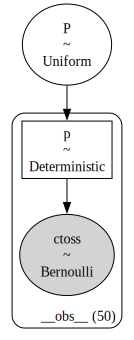

In [9]:
mod1.build()
mod1.graph()

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "example1_mod1_graph")
# mod1.graph(name=filename, fmt="png", dpi=300)

### Fitting the model

In [10]:
rng = np.random.default_rng(42)
idata1 = mod1.fit(random_seed=rng)

Modeling the probability that ctoss==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [11]:
type(idata1)

arviz.data.inference_data.InferenceData

In [12]:
idata1.groups()

['posterior', 'sample_stats', 'observed_data']

In [13]:
type(idata1["posterior"]), list(idata1["posterior"].variables)

(xarray.core.dataset.Dataset, ['chain', 'draw', 'P'])

In [14]:
print(idata1["posterior"]["P"])

<xarray.DataArray 'P' (chain: 4, draw: 1000)> Size: 32kB
array([[0.57752248, 0.76464378, 0.76804673, ..., 0.72087462, 0.6261565 ,
        0.65573748],
       [0.66847892, 0.66227121, 0.64984977, ..., 0.74399295, 0.74316843,
        0.64612716],
       [0.6536615 , 0.63571642, 0.63571642, ..., 0.72419437, 0.72419437,
        0.73746097],
       [0.69121177, 0.53349634, 0.65162582, ..., 0.71373858, 0.68736211,
        0.65542772]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999


In [15]:
# ALT. manually extract
postP = (idata1["posterior"]  # select posterior group
               ["P"]          # choose P variable
               .stack(sample=("chain", "draw"))
               .values)
postP

array([0.57752248, 0.76464378, 0.76804673, ..., 0.71373858, 0.68736211,
       0.65542772])

In [16]:
import arviz as az
postP = az.extract(idata1,
                   group="posterior",
                   var_names="P").values
postP

array([0.57752248, 0.76464378, 0.76804673, ..., 0.71373858, 0.68736211,
       0.65542772])

### Visualize the posterior

Saved figure to figures/bayes/computations/example1_histplot_postP.pdf
Saved figure to figures/bayes/computations/example1_histplot_postP.png


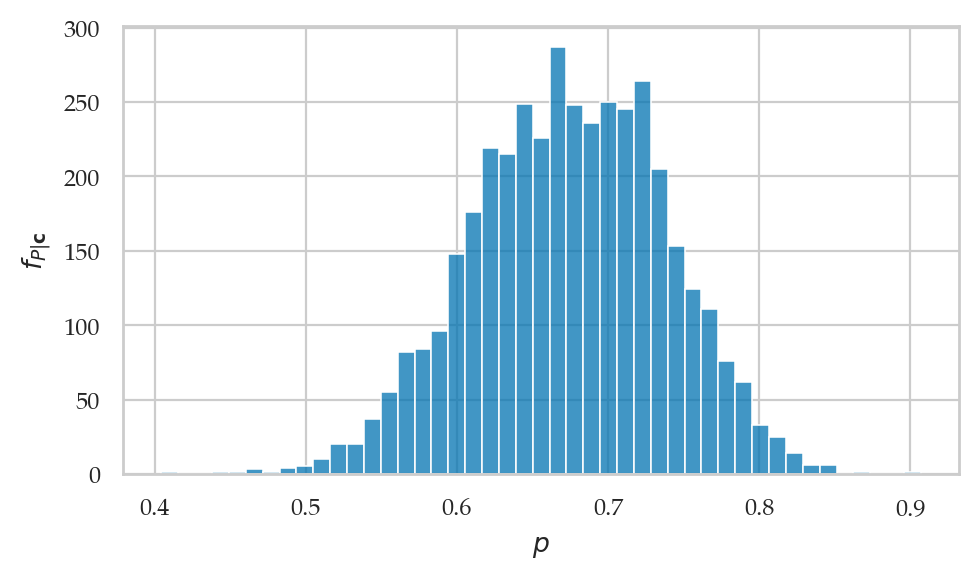

In [17]:
ax = sns.histplot(x=postP)
ax.set_xlabel("$p$")
ax.set_ylabel("$f_{P|\\mathbf{c}}$");

# FIGURES ONLY
filename = os.path.join(DESTDIR, "example1_histplot_postP.pdf")
savefigure(plt.gcf(), filename)

In [18]:
# ALT. KDE plot
# sns.kdeplot(x=postP);

### Summarize the posterior

In [19]:
len(postP)

4000

#### Posterior mean

In [20]:
postPmu = np.mean(postP)
postPmu

0.6743829911004517

#### Posterior standard deviation

In [21]:
postPvar = np.sum((postP-postPmu)**2) / len(postP)
postPstd = np.sqrt(postPvar)
postPstd

0.06374226153660453

#### Posterior median

In [22]:
np.median(postP)

0.6755330409973606

#### Posterior quartiles

In [23]:
np.quantile(postP, [0.25, 0.5, 0.75])

array([0.63005604, 0.67553304, 0.72001357])

#### Posterior percentiles

In [24]:
np.percentile(postP, [3, 97])

array([0.55306507, 0.78918945])

#### Posterior mode

In [25]:
# 1. Fit a Gaussian KDE curve approx. to the posterior samples `postP`
from scipy.stats import gaussian_kde
postP_kde = gaussian_kde(postP)

# 2. Find the max of the KDE curve
ps = np.linspace(0, 1, 10001)
densityP = postP_kde(ps)
ps[np.argmax(densityP)]

0.6697000000000001

### Credible interval

In [26]:
from ministats.hpdi import hpdi_from_samples
hpdi_from_samples(postP, hdi_prob=0.9)

[0.5663519771974564, 0.7737752346767147]

### Predictions

Let's generate some observations form the posterior predictive distribution.

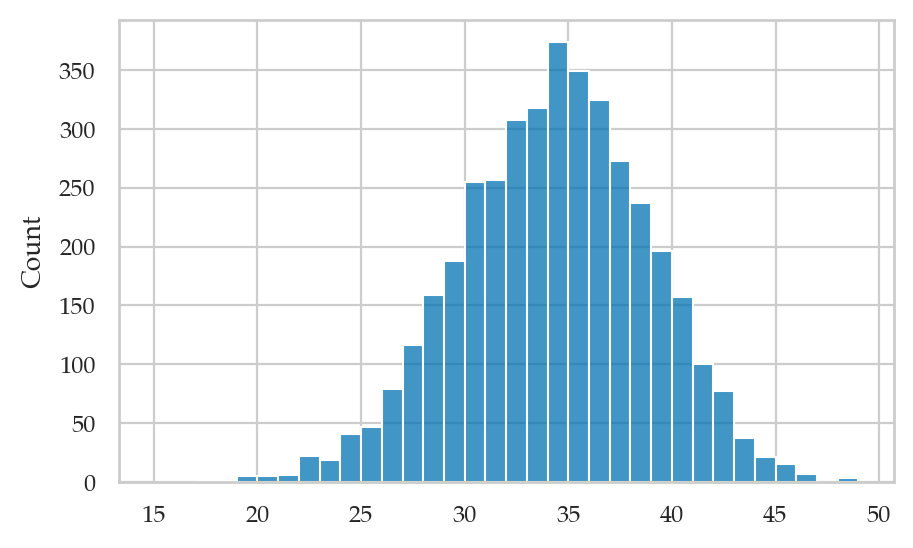

In [27]:
idata1_pred = idata1.copy()
# MAYBE: alt notation _rep instead of _pred ?
mod1.predict(idata1_pred, kind="response")
ctosses_pred = az.extract(idata1_pred,
                          group="posterior_predictive",
                          var_names="ctoss").values
numheads_pred = ctosses_pred.sum(axis=0)
sns.histplot(x=numheads_pred, bins=range(15,50));

## Example 2: estimating the IQ score

Let's return to the investigation of the smart drug effects on IQ scores.

### Data

We have collected data from $30$ individuals who took the smart drug,
which we have packaged into the `iq` column of the data frame `iqs`.

In [28]:
iqs = [ 82.6, 105.5,  96.7,  84.0, 127.2,  98.8,  94.3,
       122.1,  86.8,  86.1, 107.9, 118.9, 116.5, 101.0,
        91.0, 130.0, 155.7, 120.8, 107.9, 117.1, 100.1,
       108.2,  99.8, 103.6, 108.1, 110.3, 101.8, 131.7,
       103.8, 116.4]
iqs = pd.DataFrame({"iq":iqs})
iqs["iq"].mean()

107.82333333333334

### Model

We will use the following Bayesian model:

$$
    X \sim \mathcal{N}(M, \sigma=15),
    \qquad
    M \sim \mathcal{N}(\mu_M=100,\sigma_M=40).
$$

We place a broad prior on the mean parameter $M$,
by choosing a large value for the standard deviation $\sigma_M$.
We assume the IQ scores come from a population with standard deviation $\sigma = 15$.

In [29]:
import bambi as bmb

priors2 = {
    "Intercept": bmb.Prior("Normal", mu=100, sigma=40),
    "sigma": bmb.Prior("Data", value=15),
    # "sigma": 15,  # CHANGE WHEN https://github.com/bambinos/bambi/pull/851/files LANDS
}

mod2 = bmb.Model(formula="iq ~ 1",
                 family="gaussian",
                 link="identity",
                 priors=priors2,
                 data=iqs)

mod2.set_alias({"Intercept": "M"})
mod2

       Formula: iq ~ 1
        Family: gaussian
          Link: mu = identity
  Observations: 30
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 100.0, sigma: 40.0)
        
        Auxiliary parameters
            sigma ~ Data(value: 15.0)

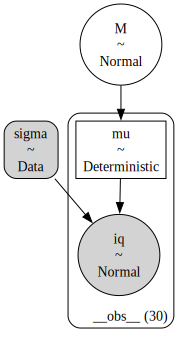

In [30]:
mod2.build()
mod2.graph()

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "example2_mod2_graph")
# mod2.graph(name=filename, fmt="png", dpi=300)

This time we'll generate $N=2000$ samples from each chain.

In [31]:
rng = np.random.default_rng(43)
idata2 = mod2.fit(draws=2000, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [32]:
idata2.groups()

['posterior', 'sample_stats', 'observed_data', 'constant_data']

In [33]:
import arviz as az
postM = az.extract(idata2,
                   group="posterior",
                   var_names="M").values
postM

array([109.9094859 , 109.9094859 , 105.65309449, ..., 103.83275866,
       112.70167463, 104.09423671])

### Visualize the posterior

Saved figure to figures/bayes/computations/example2_histplot_postM.pdf
Saved figure to figures/bayes/computations/example2_histplot_postM.png


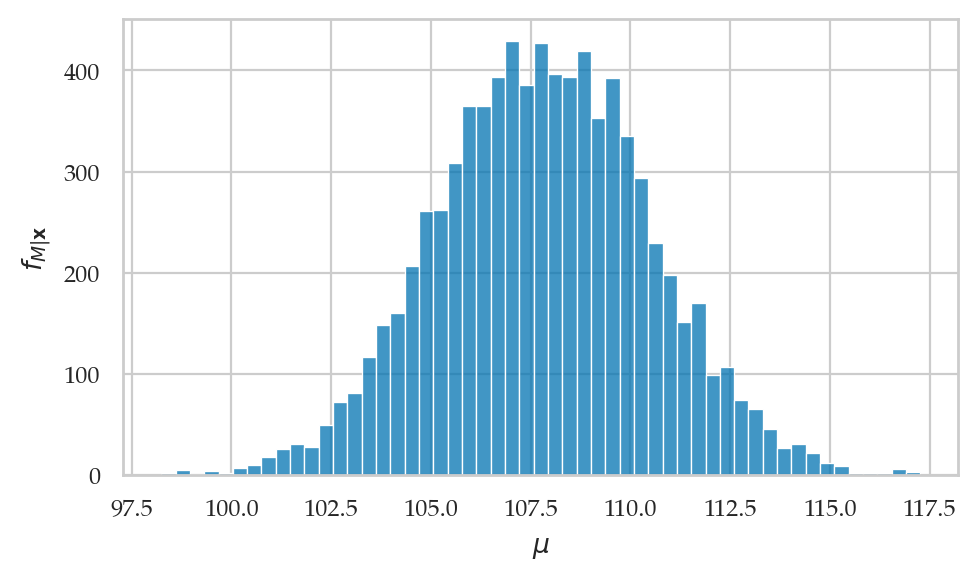

In [34]:
ax = sns.histplot(x=postM)
ax.set_xlabel("$\\mu$")
ax.set_ylabel("$f_{M|\\mathbf{x}}$");

# FIGURES ONLY
filename = os.path.join(DESTDIR, "example2_histplot_postM.pdf")
savefigure(plt.gcf(), filename)

In [35]:
# ALT. KDE plot
# sns.kdeplot(x=postM);

### Summarize the posterior

#### Posterior mean

In [36]:
postMmu = np.mean(postM)
postMmu

107.80744018578466

#### Posterior standard deviation

In [37]:
postMvar = np.sum((postM-postMmu)**2) / len(postM)
postMstd = np.sqrt(postMvar)
postMstd

2.675251508536507

#### Posterior median

In [38]:
np.median(postM)

107.79451457694034

#### Posterior quartiles

In [39]:
np.quantile(postM, [0.25, 0.5, 0.75])

array([105.98256488, 107.79451458, 109.61414691])

#### Posterior percentiles

In [40]:
np.percentile(postM, [3, 97])

array([102.84694906, 112.85728267])

#### Posterior mode

In [41]:
# 1. Fit a Gaussian KDE curve approx. to the posterior samples `postM`
from scipy.stats import gaussian_kde
postM_kde = gaussian_kde(postM)

# 2. Find the max of the KDE curve
mus = np.linspace(0, 200, 10001)
densityM = postM_kde(mus)
mus[np.argmax(densityM)]

107.42

### Credible interval

In [42]:
from ministats.hpdi import hpdi_from_samples
hpdi_from_samples(postM, hdi_prob=0.9)

[103.21158714113054, 111.9405218532474]

### Predictions

In [43]:
## Can't use Bambi predict because of issue
## https://github.com/bambinos/bambi/issues/850
# idata2_pred = mod2.predict(idata2, kind="response", inplace=False)
# preds2 = az.extract(idata2_pred, group="posterior", var_names="mu").values.flatten()

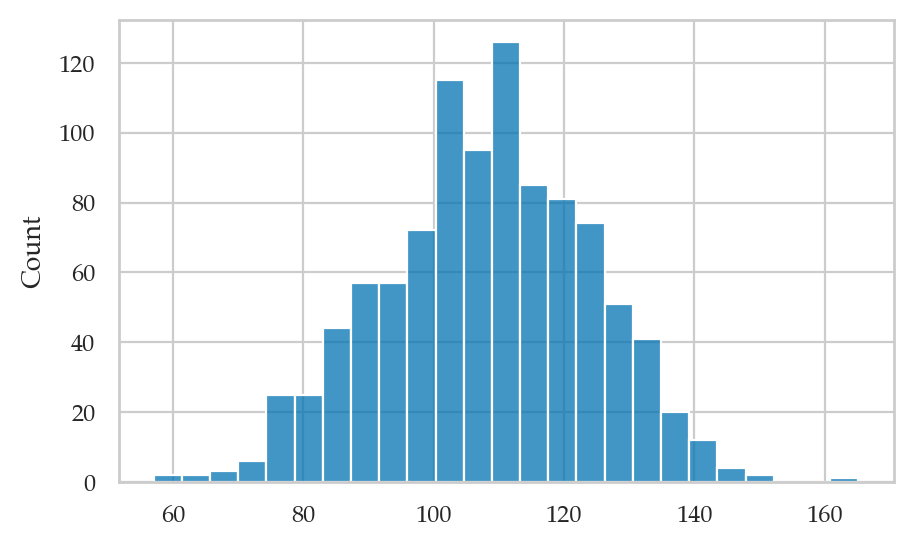

In [44]:
from scipy.stats import norm

sigma = 15  # known population standard deviation

iq_preds = []
np.random.seed(42)
for i in range(1000):
    mu_post = np.random.choice(postM)
    iq_pred = norm(loc=mu_post, scale=sigma).rvs(1)[0]
    iq_preds.append(iq_pred)

sns.histplot(x=iq_preds);

## Visualizing and interpreting posteriors

In [45]:
import arviz as az

### Example 1 continued: inferences about the biased coin

Saved figure to figures/bayes/computations/example1_arviz_plot_posterior.pdf
Saved figure to figures/bayes/computations/example1_arviz_plot_posterior.png


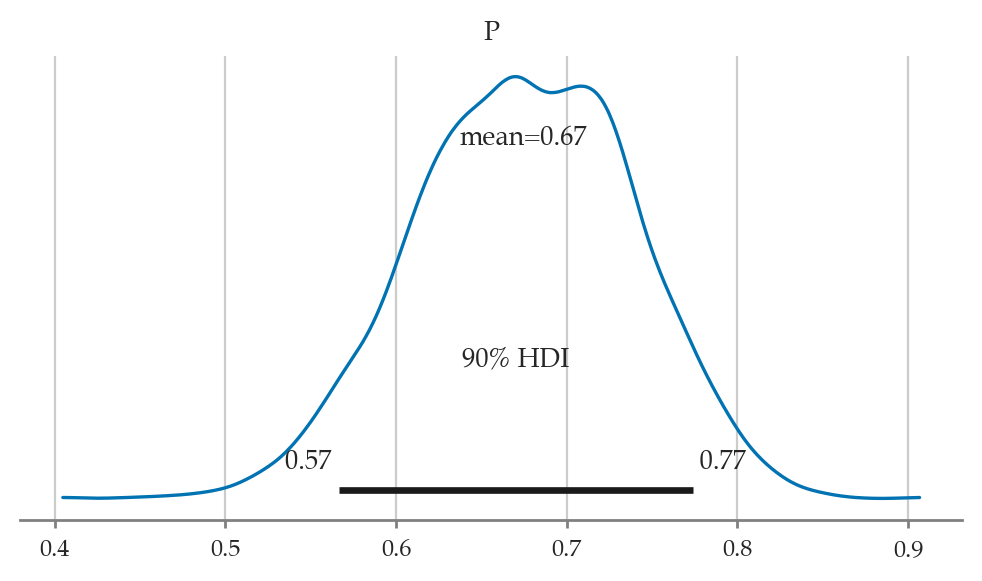

In [46]:
az.plot_posterior(idata1, hdi_prob=0.9);

# FIGURES ONLY
filename = os.path.join(DESTDIR, "example1_arviz_plot_posterior.pdf")
savefigure(plt.gcf(), filename)

Options:
- If multiple variables, you specify a list to `var_names` to select only certain variables to plot
- Set the option `point_estimate` to `"mode"` or `"median"`
- Add the option `rope` to draw region of practical equivalence,
  e.g., `rope=[97,103]`

In [47]:
az.summary(idata1, kind="stats", hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%
P,0.674,0.064,0.566,0.774


In [48]:
az.summary(idata1, kind="stats", stat_focus="median")

,median,mad,eti_3%,eti_97%
P,0.676,0.045,0.553,0.789


### Example 2 continued: inferences about the population mean

Saved figure to figures/bayes/computations/example2_arviz_plot_posterior.pdf
Saved figure to figures/bayes/computations/example2_arviz_plot_posterior.png


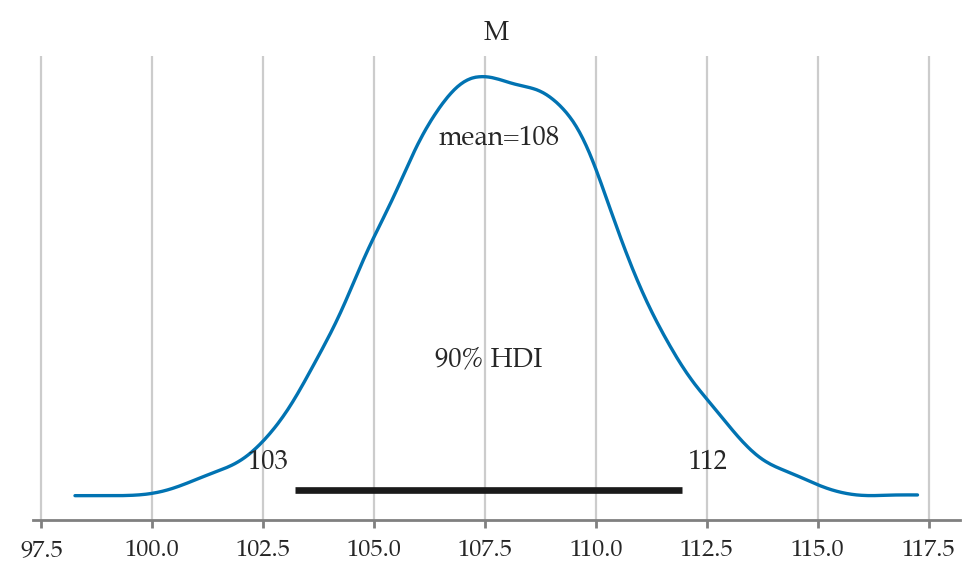

In [49]:
az.plot_posterior(idata2, hdi_prob=0.9);

# FIGURES ONLY
filename = os.path.join(DESTDIR, "example2_arviz_plot_posterior.pdf")
savefigure(plt.gcf(), filename)

In [50]:
az.summary(idata2, kind="stats", hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%
M,107.807,2.675,103.212,111.941


In [51]:
az.summary(idata2, kind="stats", stat_focus="median")

,median,mad,eti_3%,eti_97%
M,107.795,1.817,102.847,112.857


## Explanations

### Choosing priors

TODO: insert text

- informative
- weakly informative
- noninformative



### Bambi default priors

In [52]:
import bambi as bmb

mod2d = bmb.Model("iq ~ 1", family="gaussian", data=iqs)
mod2d.set_alias({"Intercept":"M"})
mod2d

       Formula: iq ~ 1
        Family: gaussian
          Link: mu = identity
  Observations: 30
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 107.8233, sigma: 39.5303)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 15.8121)

In [53]:
iqs["iq"].mean(), iqs["iq"].std(), 2.5*iqs["iq"].std()

(107.82333333333334, 16.082431694100315, 40.20607923525078)

In [54]:
# mod2d.build()
# mod2d.plot_priors();

### More info about data inference objects

In [55]:
type(idata1)

arviz.data.inference_data.InferenceData

In [56]:
idata1.groups()

['posterior', 'sample_stats', 'observed_data']

In [57]:
posterior1 = idata1["posterior"]
type(posterior1)

xarray.core.dataset.Dataset

In [58]:
posterior1.dims

FrozenMappingWarningOnValuesAccess({'chain': 4, 'draw': 1000})

In [59]:
list(posterior1.variables)

['chain', 'draw', 'P']

In [60]:
Ps = posterior1["P"]
type(Ps)

xarray.core.dataarray.DataArray

In [61]:
Ps.dims, Ps.shape

(('chain', 'draw'), (4, 1000))

### MCMC diagnostics


#### MCMC diagnostic plots

There are several Arviz plots we can use to check if the Markov Chain Monte Carlo chains were sampling from the posterior as expected, or ...

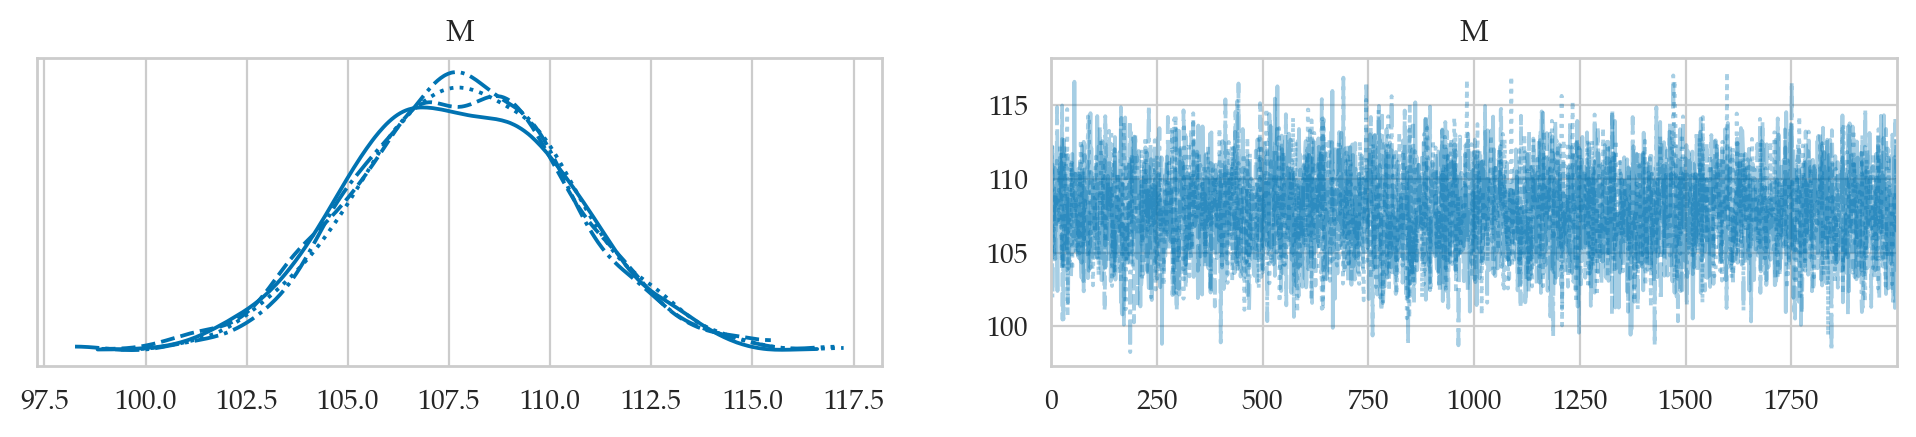

In [62]:
az.plot_trace(idata2);

Saved figure to figures/bayes/computations/example2_diagnostics_trace.pdf
Saved figure to figures/bayes/computations/example2_diagnostics_trace.png


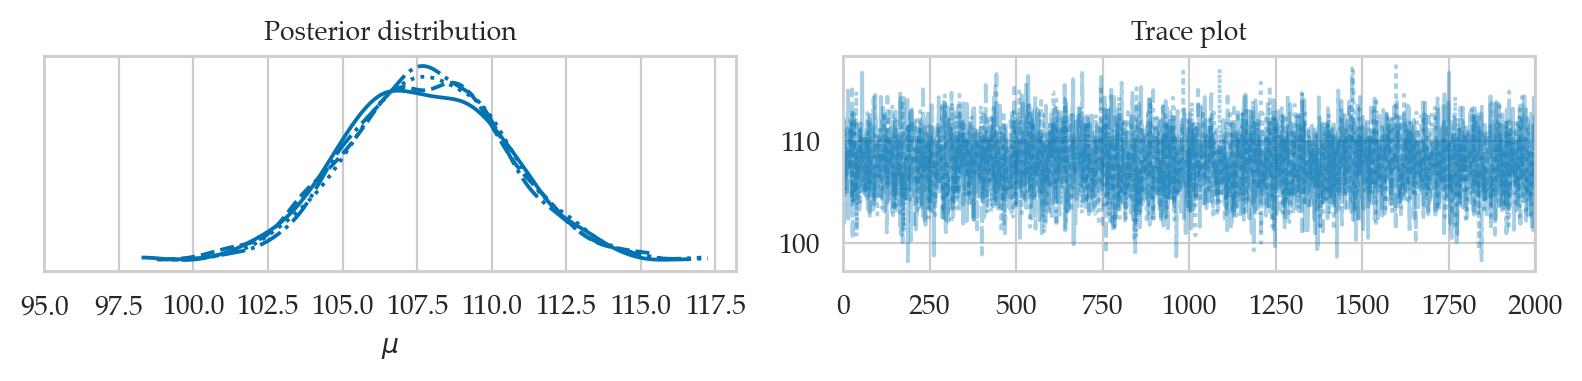

In [63]:
# FIGURES ONLY
axs = az.plot_trace(idata2, figsize=(8,2))
ax1, ax2 = axs[0,0], axs[0,1]
#
ax1.set_title("Posterior distribution")
ax1.set_xlabel("$\\mu$")
ax1.set_xticks(np.arange(95,120,2.5))
# 
ax2.set_title("Trace plot")
ax2.set_xticks(np.arange(0,2001,250))

filename = os.path.join(DESTDIR, "example2_diagnostics_trace.pdf")
savefigure(plt.gcf(), filename)

In [64]:
ax1.ticklabel_format

<bound method _AxesBase.ticklabel_format of <Axes: title={'center': 'Posterior distribution'}, xlabel='$\\mu$'>>

In [65]:
az.summary(idata2, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
M,0.045,0.032,3585.0,5573.0,1.0


In [66]:
# MAYBE (ask Chelsea)
# az.plot_trace(idata2, kind="rank_bars");

## Bayesian workflow

See also [chp_09.ipynb](./explorations/PyBayesianBookCode/notebooks_updated/chp_09.ipynb)

Sampling: [P]


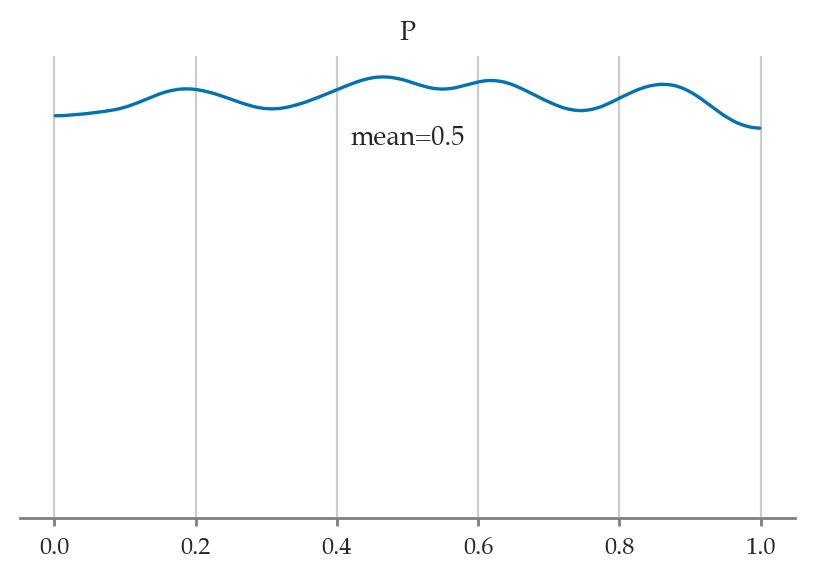

In [70]:
# BONUS: verify the prior was flat
rng = np.random.default_rng(43)
mod1.plot_priors(random_seed=rng, hdi_prob="hide");

In [68]:
# mod1.prior_predictive()

## Discussion

### Conjugate priors

### Probabilistic programming languages

### Computational cost

### Reporting Bayesian results

## Exercises

TODO: repeat exercises form Sec 5.1 using Bambi and ArviZ

## Links

TODO